In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
from keras import backend as K
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from tqdm import tqdm
from sklearn.utils import shuffle
from tensorflow.keras import layers
from tensorflow import keras
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.11.0


In [3]:
pth = '/kaggle/input/image-resolution/Dataset/LR/sample1.npy'
img =np.load(pth)
img.shape

(1, 75, 75)

In [4]:
path = '/kaggle/input/image-resolution/Dataset/'

# Resizing Images

In [5]:
def modify_HR(image):
    image = image.reshape((150,150,1))
    img = tf.reshape(tf.broadcast_to(image, (150, 150, 3)),  (150, 150, 3))
    return img

def modify_LR(image):
    image = image.reshape((75,75,1))
    img = tf.reshape(tf.broadcast_to(image, (75, 75, 3)),  (75, 75, 3))
    return img

> # CUSTOM DATA GENERATOR
**Since Dataset was Large enough to handle , We need efficient way to take care of it.**
Notations
Before getting started, let's go through a few organizational tips that are particularly useful when dealing with large datasets.
Let ID be the Python string that identifies a given sample of the dataset. A good way to keep track of samples and their labels is to adopt the following framework:
> > 1.) Create a dictionary called partition where you gather:
> > > in partition['train'] a list of training IDs

> > > in partition['validation'] a list of validation IDs

> > 2.) Create a dictionary called labels where for each ID of the dataset, the associated label is given by labels[ID]

> First, let's write the initialization function of the class. We make the latter inherit the properties of keras.utils.Sequence so that we can leverage nice functionalities such as multiprocessing.

> We put as arguments relevant information about the data, such as dimension sizes (e.g. a volume of length 32 will have dim=(32,32,32)), number of channels, number of classes, batch size, or decide whether we want to shuffle our data at generation. We also store important information such as labels and the list of IDs that we wish to generate at each pass.

> Here, the method on_epoch_end is triggered once at the very beginning as well as at the end of each epoch. If the shuffle parameter is set to True, we will get a new order of exploration at each pass (or just keep a linear exploration scheme otherwise).

> Shuffling the order in which examples are fed to the classifier is helpful so that batches between epochs do not look alike. Doing so will eventually make our model more robust.

> Another method that is core to the generation process is the one that achieves the most crucial job: producing batches of data. The private method in charge of this task is called __data_generation and takes as argument the list of IDs of the target batch.

> During data generation, this code reads the NumPy array of each example from its corresponding file ID.npy. Since our code is multicore-friendly, note that you can do more complex operations instead (e.g. computations from source files) without worrying that data generation becomes a bottleneck in the training process.

> Also, please note that we used Keras' keras.utils.to_categorical function to convert our numerical labels stored in y to a binary form (e.g. in a 6-class problem, the third label corresponds to [0 0 1 0 0 0]) suited for classification.

> Now comes the part where we build up all these components together. Each call requests a batch index between 0 and the total number of batches, where the latter is specified in the __len__ method.

> A common practice is to set this value to
                ⌊#samples/batch size⌋
so that the model sees the training samples at most once per epoch.
Now, when the batch corresponding to a given index is called, the generator executes the __getitem__ method to generate it.


In [6]:
import numpy as np
import keras
import os
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, dim_LR=(75,75),dim_HR = (150,150), n_channels=1,n_classes=10, shuffle=True):
        'Initialization'
        self.dim_LR = dim_LR
        self.dim_HR = dim_HR
        self.batch_size = batch_size
#         self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            


    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim_LR, self.n_channels))
        y = np.empty((self.batch_size, *self.dim_HR, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            k = ID.split('_')
            img = np.load('/kaggle/input/image-resolution/Dataset/' + '/'.join(k))
            img = modify_LR(img)
            X[i,] = img
            y[i,] = modify_HR(np.load('/kaggle/input/image-resolution/Dataset/' +'HR/'+k[1]))

        return np.array(X), np.array(y)

# Dictionary

In [7]:
import random
from tqdm import tqdm
from sklearn.utils import shuffle
trains = []
train_labels = []
labels = {}
trains = ['LR_'+str(i) for i in os.listdir(path+'LR')]
shuffle(trains)
train = trains[:9000]
val = trains[9000:10000]

In [8]:
partition = {'train': train , 'validation' : val}
params = {'dim_LR': (75,75),
          'dim_HR': (150,150),
          'batch_size': 2,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True}


# Generators
training_generator = DataGenerator(partition['train'],  **params)
validation_generator = DataGenerator(partition['validation'], **params)

# Peak Signal To Noise Ratio and Structural Similarity Index

In [9]:
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

def SSIM(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))


def model_train_plot(history):
    
    
    plt.plot(history.history['root_mean_squared_error'])
    plt.plot(history.history['val_root_mean_squared_error'])
    plt.title('Root Mean Squared Error')
    plt.ylabel('error')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    

    plt.plot(history.history['SSIM'])
    plt.plot(history.history['val_SSIM'])
    plt.title('model SSIM')
    plt.ylabel('SSIM')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['PSNR'])
    plt.plot(history.history['val_PSNR'])
    plt.title('model PSNR')
    plt.ylabel('PSNR')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    



# Model

In [10]:
def build_model():
    model = keras.Sequential()
    model.add(keras.Input(shape = (75,75,3)))
    model.add(layers.Conv2D(filters = 32, kernel_size= 3, padding = 'same', strides = 1,activation='relu'))
    model.add(layers.Conv2D(filters = 64, kernel_size= 3, padding = 'same', activation='relu'))
    model.add(layers.Conv2D(filters = 128, kernel_size= 9, padding = 'same', activation='relu' ))
    model.add(layers.Conv2D(filters = 64, kernel_size= 9, padding = 'same', activation='relu'))
    model.add(layers.UpSampling2D(size = (2,2)))
    model.add(layers.Conv2D(filters = 64, kernel_size= 3, padding = 'same', activation='relu'))
    model.add(layers.Conv2D(filters = 128, kernel_size= 9, padding = 'same', activation='relu'))
    model.add(layers.Conv2D(filters = 32, kernel_size= 3, padding = 'same', activation='relu'))
    model.add(layers.Conv2D(filters = 32, kernel_size= 3, padding = 'same', activation='relu'))
#     model.add(layers.UpSampling2D(size = (2,2)))
    model.add(layers.Dense(3, activation="relu"))
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(optimizer = opt, loss = tf.keras.losses.MeanSquaredError(), metrics = [PSNR,tf.keras.metrics.RootMeanSquaredError(), SSIM])
    model.summary()
    return model

In [11]:
model = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 75, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 128)       663680    
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        663616    
                                                                 
 up_sampling2d (UpSampling2D  (None, 150, 150, 64)     0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 64)      36928     
                                                        

In [12]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

history = model.fit(training_generator, batch_size=2, epochs=50, verbose= 1,
                   callbacks=[earlystop_callback], validation_data = validation_generator)

Epoch 1/50
4500/4500 [==============================] - 314s 68ms/step - loss: 1.7897e-04 - PSNR: 49.5883 - root_mean_squared_error: 0.0134 - SSIM: 0.9854 - val_loss: 6.1034e-05 - val_PSNR: 50.5863 - val_root_mean_squared_error: 0.0078 - val_SSIM: 0.9904
Epoch 2/50
4500/4500 [==============================] - 273s 61ms/step - loss: 6.4532e-05 - PSNR: 50.6172 - root_mean_squared_error: 0.0080 - SSIM: 0.9902 - val_loss: 7.7576e-05 - val_PSNR: 49.5490 - val_root_mean_squared_error: 0.0088 - val_SSIM: 0.9874
Epoch 3/50
4500/4500 [==============================] - 274s 61ms/step - loss: 6.1556e-05 - PSNR: 50.6799 - root_mean_squared_error: 0.0078 - SSIM: 0.9903 - val_loss: 5.9548e-05 - val_PSNR: 50.9134 - val_root_mean_squared_error: 0.0077 - val_SSIM: 0.9905
Epoch 4/50
4500/4500 [==============================] - 276s 61ms/step - loss: 6.0804e-05 - PSNR: 50.9070 - root_mean_squared_error: 0.0078 - SSIM: 0.9905 - val_loss: 5.9082e-05 - val_PSNR: 51.0285 - val_root_mean_squared_error: 0.0077

# Plot The PSNR and SSIM

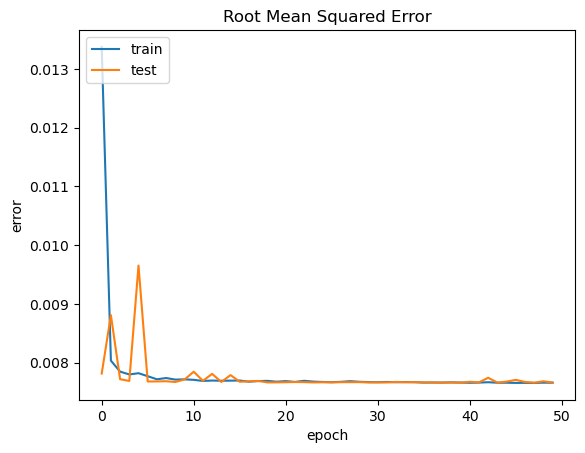

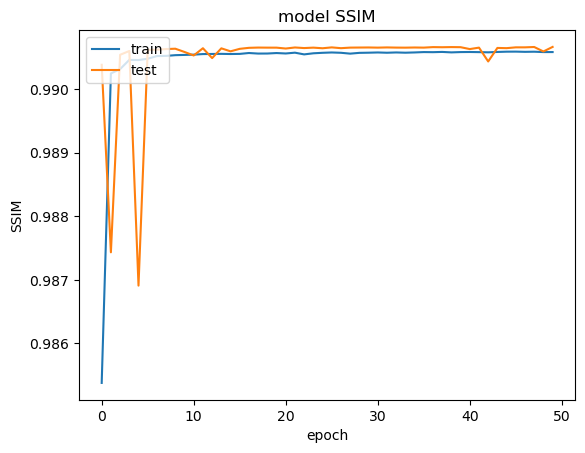

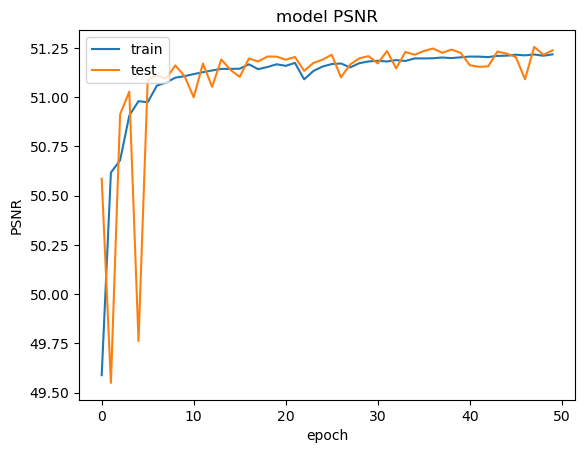

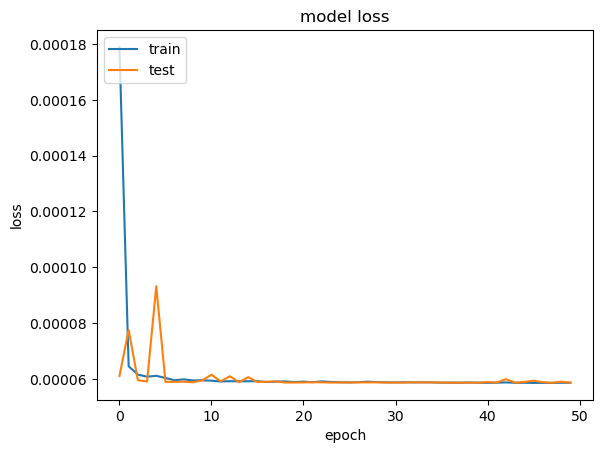

In [13]:
model_train_plot(history)